In [1]:
#| default_exp rotation

In [2]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import wrapping as tcwrap

import numpy as np
from copy import deepcopy
import warnings
import igl

from scipy import integrate, interpolate, ndimage, optimize, sparse, spatial, special
from skimage import registration, transform

import matplotlib as mpl

import skfmm

import itertools

In [3]:
from tqdm.notebook import tqdm
from importlib import reload

import matplotlib.pyplot as plt
from scipy import stats

In [4]:
np.set_printoptions(suppress=True)

## Registering data with respect to 3d rotations

Here, we build tools to rotationally align data defined on a 2d-sphere using spherical harmonics. We consider the following problem: given two scalar functions $f,h: S^2 \rightarrow \mathbb{R}$ on the sphere, find the rotation $g\in SO(3)$ that best aligns them, in the sense that it maximizes $\int d\Omega f(x) h(g^{-1}x)$.

We do this by expanding the functions in terms of spherical harmonics, and using the Wigner d-matrices to compute the effect of rotation.

In principle, the above could be done more efficiently using the fast spherical harmonics transform and the fast Wigner transform. To minimize depedencies and keep the code simple, we won't do so here.

We will represent spherical harmonics coefficients as `dict`s, indexed by total angular momentum $l$, with an entry being a vector for the different $m=-l,..., l$. Since we have real signals, we can get negative $m$ from the positive ones.

In [19]:
# let's get a test case - a mesh obtained by mapping a mesh conformally to the sphere

mesh = tcio.ObjMesh.read_obj("movie_example/map_to_sphere.obj")
mesh_3d = tcio.ObjMesh.read_obj("movie_example/final_uv.obj")

In [7]:
#| export

def cartesian_to_spherical(arr):
    """
    Convert cartesian coordinates to spherical coordinates.
    
    Uses en.wikipedia.org/wiki/Spherical_coordinate_system convention.
    
    Parameters
    ----------
    arr : np.array of shape (..., 3)
        array of x/y/z coordinates. last axis indexes coordinate axes.
        
    Returns
    -------
    r, theta, phi : np.arrays
        Spherical coordinates
    """
    r = np.linalg.norm(arr, axis=-1)
    theta = np.arccos(arr[...,2]/r)
    phi = np.sign(arr[...,1])*np.arccos(arr[...,0]/np.linalg.norm(arr[...,:2], axis=-1))
    return r, theta, phi

In [20]:
# as test signal, let's use the log(areas) of the mesh triangles

areas_sphere = igl.doublearea(mesh.vertices, mesh.tris)
areas_3d = igl.doublearea(mesh_3d.vertices, mesh_3d.tris)

signal = np.log(areas_sphere/areas_3d)
signal -= signal.mean()

centroids = mesh.vertices[mesh.tris].mean(axis=1)
_, theta, phi = cartesian_to_spherical(centroids)

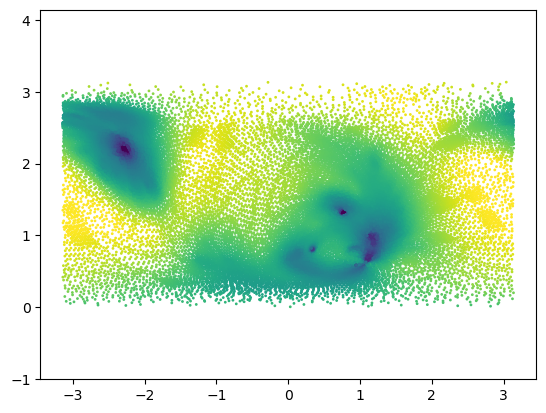

In [21]:
plt.scatter(phi, theta, c=signal, s=1, vmin=-3, vmax=3)
plt.axis("equal");

In [22]:
## interpolate onto a grid as a check

n_grid = 256
phi_grid, theta_grid = np.meshgrid(np.linspace(-np.pi,np.pi, 2*n_grid), np.linspace(0, np.pi, n_grid)[::-1], )
interpolated = interpolate.griddata(np.stack([phi, theta], axis=-1), signal,
                                    (phi_grid, theta_grid), method='linear')
dTheta = np.pi/(n_grid-1)
dPhi = 2*np.pi/(2*n_grid-1)
interpolated = np.nan_to_num(interpolated)

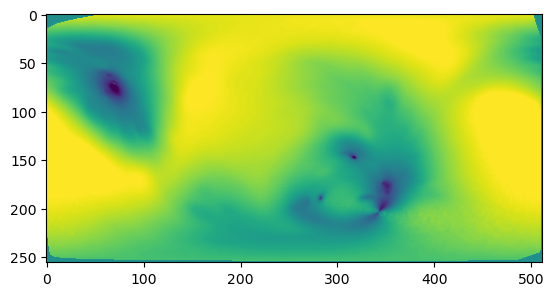

In [23]:
plt.imshow(interpolated, vmin=-2.75, vmax=2.75)

In [24]:
# check normalization and orthogonality of spherical harmonics for grid

print(np.sum(np.abs(special.sph_harm(1, 2, phi_grid, theta_grid))**2 * np.sin(theta_grid) * dTheta * dPhi))
print(np.abs(np.sum(special.sph_harm(2, 3, phi_grid, theta_grid)
              *np.conjugate(special.sph_harm(2, 4, phi_grid, theta_grid))
              *np.sin(theta_grid)*dTheta*dPhi)))

1.0019569486052557
1.0290434898119816e-16


In [25]:
# check relation between negative and positive m. Keep in mind (-1)^m factor

l, m = (4, 3)
np.allclose((-1)**(-m) * np.conjugate(special.sph_harm(m, l, phi_grid,theta_grid)),
            special.sph_harm(-m, l, phi_grid,theta_grid))

True

In [26]:
# now let's do the direct calculation without extra interpolation. Check orthonormality

weights = igl.doublearea(mesh.vertices, mesh.tris)/2

print(np.sum(np.abs(special.sph_harm(1, 2, phi, theta))**2 * weights))
print(np.abs(np.sum(special.sph_harm(2, 3, phi, theta)
              *np.conjugate(special.sph_harm(2, 4, phi, theta))
              *weights)))

0.9995216459251891
8.587490037829243e-05


In [27]:
#| export

def compute_spherical_harmonics_coeffs(f, phi, theta, weights, max_l):
    """
    Compute spherical harmonic coefficients for a scalar real-valued function defined on the unit sphere.
    
    Takes as input values of the function at sample points (and sample weights), and computes
    the overlap with each spherical harmonic by "naive" numerical integration.
    
    Since the function is assumed real, we have f^{l}_{-m} = np.conjugate(f^{l}_{m}).
    
    Parameters
    ----------
    f : np.array 
        Sample values
    phi : np.array of shape
        Sample point azimuthal coordinates
    theta : np.array of shape
        Sample point longditudinal coordinates
    weights : np.array
        Sample weights. For instance, if you have a function sampled on a regular phi-theta grid,
        this should be dTheta*dPhi*np.sin(theta)
    max_l : int
        Maximum angular momentum
        
    Returns
    -------
    coeffs : dict of np.array
        Dictionary, indexed by total angular momentum l=0 ,..., max_l. Each entry is a vector
        of coefficients for the different values of m=-2l,...,2*l
    """

    coeffs = {}
    for l in range(max_l):
        vec = np.zeros(max([1, 2*l+1]), dtype="complex_")
        for m in range(0, l+1):
            entry = np.sum(weights*f*special.sph_harm(m, l, phi, theta))
            vec[l+m] = entry
            vec[l-m] = np.conjugate(entry)*(-1)**m
        coeffs[l] = np.copy(vec)
    return coeffs

In [28]:
%%time

weights_grid = np.sin(theta_grid)*dTheta*dPhi
spherical_harmonics_coeffs = compute_spherical_harmonics_coeffs(interpolated, phi_grid, theta_grid,
                                                                weights_grid, max_l=15)

CPU times: user 1.67 s, sys: 0 ns, total: 1.67 s
Wall time: 1.67 s


In [29]:
spherical_harmonics_coeffs[3]

array([-0.16933537-0.20499241j,  0.2511679 -0.59427039j,
        0.10986489-0.22857625j, -0.39380713-0.j        ,
       -0.10986489-0.22857625j,  0.2511679 +0.59427039j,
        0.16933537-0.20499241j])

In [30]:
#| export

def spherical_harmonics_to_grid(coeffs, n_grid=256):
    """
    Compute signal on rectangular phi-theta grid given spherical harmonics coefficients.
    
    Assumes underlying function is real-valued
    
    Parameters
    ----------
    coeffs : dict of np.array
        Dictionary, indexed by total angular momentum l=0 ,..., max_l. Each entry is a vector
        of coefficients for the different values of m=-2l,...,2*l
    
    Returns
    -------
    reconstructed : 2d np.array
        Reconstructed signal interpolated on rectangular phi-theta grid
    
    """
    phi_grid, theta_grid = np.meshgrid(np.linspace(-np.pi,np.pi, 2*n_grid), np.linspace(0, np.pi, n_grid)[::-1], )
    reconstructed = np.zeros_like(phi_grid, dtype="complex_")
    for l, coeff_vec in coeffs.items():
        for m in range(0, l+1):
            Y_ml = special.sph_harm(m, l, phi_grid, theta_grid)
            if m == 0:
                reconstructed += coeff_vec[l]*Y_ml
            else:
                reconstructed += (coeff_vec[l+m]*np.conjugate(Y_ml)+coeff_vec[l-m]*Y_ml*(-1)**m)
    return reconstructed

In [31]:
reconstructed = spherical_harmonics_to_grid(spherical_harmonics_coeffs, n_grid=256)

In [32]:
np.abs(reconstructed.imag).mean(), np.abs(reconstructed.real).mean() # as

(2.3898829015069598e-17, 1.7166253842801795)

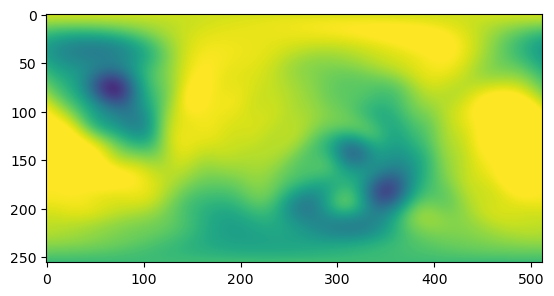

In [33]:
plt.imshow(reconstructed.real, vmin=-2.75, vmax=2.75)

In [44]:
## now without the extra interpolation step

max_l = 15

weights = igl.doublearea(mesh.vertices, mesh.tris)/2
spherical_harmonics_coeffs_direct = compute_spherical_harmonics_coeffs(signal, phi, theta, weights,
                                                                       max_l=max_l)

In [45]:
reconstructed_direct = spherical_harmonics_to_grid(spherical_harmonics_coeffs_direct, n_grid=256)

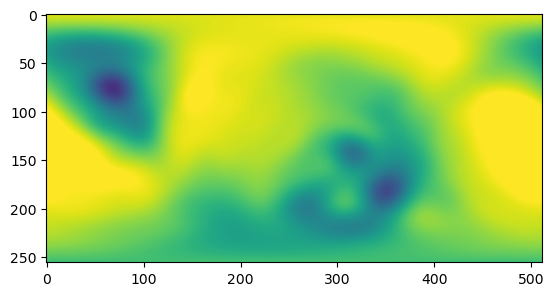

In [46]:
plt.imshow(reconstructed_direct.real, vmin=-2.75, vmax=2.75)

### Rotational alignment

As a test, let's randomly rotate our signal.

In [47]:
rot_mat = stats.special_ortho_group.rvs(3)
rot_mat

array([[ 0.22819409,  0.03778288, -0.97288227],
       [ 0.96451705, -0.14506291,  0.22059832],
       [-0.13279429, -0.98870077, -0.06954473]])

In [48]:
mesh_rotated = deepcopy(mesh)
mesh_rotated.vertices = mesh_rotated.vertices @ rot_mat.T

In [51]:
areas_sphere_rotated  = igl.doublearea(mesh_rotated.vertices , mesh.tris)

signal_rotated = np.log(areas_sphere_rotated/areas_3d)
signal_rotated -= signal_rotated.mean()

centroids_rotated = mesh_rotated.vertices[mesh_rotated.tris].mean(axis=1)
_, theta_rotated, phi_rotated = cartesian_to_spherical(centroids_rotated)

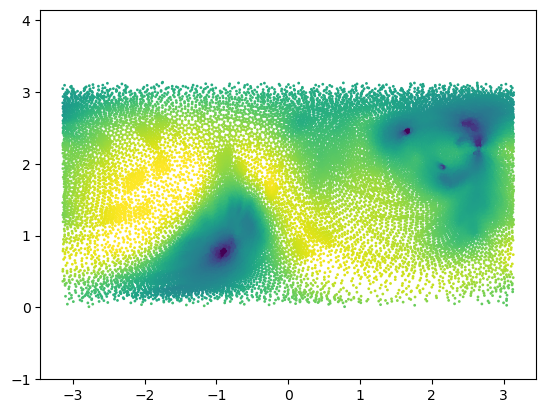

In [52]:
plt.scatter(phi_rotated, theta_rotated, c=signal_rotated , s=1, vmin=-3, vmax=3)
plt.axis("equal");

In [53]:
weights_rotated = igl.doublearea(mesh_rotated.vertices, mesh.tris)/2
spherical_harmonics_coeffs_rotated = compute_spherical_harmonics_coeffs(signal_rotated,
                                                                        phi_rotated, theta_rotated,
                                                                        weights_rotated, max_l=max_l)

In [54]:
# let's check that the power per band is conserved
power_direct = {key: np.sum(np.abs(val)**2) for key, val in spherical_harmonics_coeffs_direct.items()}
power_rotated = {key: np.sum(np.abs(val)**2) for key, val in spherical_harmonics_coeffs_rotated.items()}

In [55]:
power_direct

{0: 35.95594799547801,
 1: 1.1368211386378588,
 2: 8.430358021856142,
 3: 1.2804779339229635,
 4: 1.203958507742655,
 5: 0.32442243670754617,
 6: 0.1413669473549429,
 7: 0.14120440763572673,
 8: 0.08558487331711022,
 9: 0.09535300292619119,
 10: 0.047359585340836646,
 11: 0.049622525642459586,
 12: 0.028208239266213495,
 13: 0.029224398275558765,
 14: 0.018700176549751396}

In [56]:
power_rotated

{0: 35.95594799547801,
 1: 1.1368211386378595,
 2: 8.430358021856145,
 3: 1.280477933922963,
 4: 1.203958507742653,
 5: 0.32442243670754684,
 6: 0.14136694735494287,
 7: 0.14120440763572736,
 8: 0.08558487331710972,
 9: 0.09535300292618955,
 10: 0.047359585340837,
 11: 0.049622525642460925,
 12: 0.028208239266214692,
 13: 0.02922439827556017,
 14: 0.018700176549750706}

### Inference of the rotation matrix from the spherical harmonics

Now for the difficult part. We need to infer the rotation matrix. The spherical harmonics will transform in blocks for each $n$. Wigner D-matrices describe how. The code below is based on https://github.com/moble/spherical.

#### Check that the Wigner D fixes our rotation issues

In [57]:
# Load the spherical module for comparison, even though we will re-implement it to minimize dependencies

import quaternionic
import spherical

In [59]:
# indeed, using the correct Wigner matrix can undo our rotation

wigner = spherical.Wigner(15)
D = wigner.D(quaternionic.array.from_rotation_matrix(rot_mat))

l = 5
mp = 3

np.sum([D[wigner.Dindex(l, mp, m)]*spherical_harmonics_coeffs_direct[l][l+m]
        for m in range(-l, l+1)]), spherical_harmonics_coeffs_rotated[l][l+mp]

((-0.11855088026806485+0.03726842522260342j),
 (-0.11855088026806437+0.03726842522260229j))

#### Quaternions and rotation

Rotations can be respresensted by unit quaternion $\mathbf{q}=(q_1, q_i, q_j, q_k)$. The spatial part $(q_i,q_j,q_k)$ defines the orientation of the rotation axis, and $\alpha=2\arccos(u_1)$ is the rotation angle.
For a unit vector $\mathbf{u}$ defining the orientation of rotation and rotation angle $\alpha$:
$$q = \sin(\alpha/2) \mathbf{u} + \cos(\alpha/2)$$
See https://fr.wikipedia.org/wiki/Quaternions_et_rotation_dans_l%27espace


In [60]:
#| export

def quaternion_to_rot_max(q):
    """
    Convert unit quaternion into a 3d rotation matrix.
    
    See https://fr.wikipedia.org/wiki/Quaternions_et_rotation_dans_l%27espace
    """
    assert np.allclose(np.linalg.norm(q), 1), "Must be unit quaternion!"
    a, b, c, d = q
    return np.array([[a**2+b**2-c**2-d**2, 2*b*c-2*a*d, 2*a*c+2*b*d],
                     [2*a*d+2*b*c, a**2-b**2+c**2-d**2, 2*c*d-2*a*b],
                     [2*b*d-2*a*c, 2*a*b+2*c*d, a**2-b**2-c**2+d**2]])

def rot_mat_to_quaternion(Q):
    """
    Convert 3d rotation matrix into unit quaternion.
    
    See https://fr.wikipedia.org/wiki/Quaternions_et_rotation_dans_l%27espace
    """
    trace = np.trace(Q)
    if trace < (-1+1e-5): # rotation by pi
        vals, vecs = np.linalg.eig(Q)
        u = vecs[:,np.argmin(np.abs(vals-1))].real
        return np.hstack([[0], u])
    r = np.sqrt(1+trace)/2
    u_ind = np.argmax(np.abs(np.diag(Q)))
    q = np.array([r, 0, 0, 0])
    Q_anti = (Q-Q.T)/(4*r)
    q[1+(u_ind+0)%3] = Q_anti[(u_ind+2)%3,(u_ind+1)%3]
    q[1+(u_ind+1)%3] = Q_anti[(u_ind+0)%3,(u_ind+2)%3]
    q[1+(u_ind+2)%3] = Q_anti[(u_ind+1)%3,(u_ind+0)%3]
    return q

def conjugate_quaternion(q):
    """Conjugate a quaternion"""
    return np.array([1, -1, -1, -1]) * q

def invert_quaternion(q):
    """Invert a quaternion"""
    return conjugate_quaternion(q) / np.linalg.norm(q)

def multiply_quaternions(q, p):
     return np.array([q[0]*p[0]-q[1]*p[1]-q[2]*p[2]-q[3]*p[3],
                      q[0]*p[1]+q[1]*p[0]+q[2]*p[3]-q[3]*p[2],
                      q[0]*p[2]+q[2]*p[0]-q[1]*p[3]+q[3]*p[1],
                      q[0]*p[3]+q[3]*p[0]+q[1]*p[2]-q[2]*p[1]])
    
def quaternion_power(q, n):
    """Raise quaternion to integer power, potentially negative"""
    assert isinstance(n, int), "power n must be integer"
    if n == 0:
        return np.array([1,0,0,0])
    if n > 0:
        n_iter = n
        q_inverted = q
    elif n < 0:
        n_iter = -n
        q_inverted = invert_quaternion(q)
    res = np.copy(q_inverted)
    while n_iter > 1:
        res = multiply_quaternions(q_inverted,res)
        n_iter -= 1
    return res

def quaternion_to_complex_pair(q):
    """Convert quaternion to pair of complex numbers q0+iq3, q2+iq1"""
    return q[0]+1j*q[3], q[2]+1j*q[1]

In [61]:
Q = stats.special_ortho_group.rvs(3)
print(Q)

[[ 0.27600873  0.06864074 -0.95870101]
 [-0.50406228  0.85961437 -0.08357248]
 [ 0.81837669  0.50631175  0.27186028]]


In [62]:
np.array(quaternionic.array.from_rotation_matrix(Q))/rot_mat_to_quaternion(Q)

array([-1., -1., -1., -1.])

In [63]:
q = rot_mat_to_quaternion(Q)
Q_back = quaternion_to_rot_max(q)
np.allclose(Q_back, Q)

True

In [64]:
Q1 = stats.special_ortho_group.rvs(3)
Q2 = stats.special_ortho_group.rvs(3)

R1 = quaternionic.array.from_rotation_matrix(Q1)
R2 = quaternionic.array.from_rotation_matrix(Q2)

In [65]:
R1 * R2

quaternionic.array([-0.82178711,  0.07627212, -0.08300003,  0.55853334])

In [66]:
multiply_quaternions(rot_mat_to_quaternion(Q1), rot_mat_to_quaternion(Q2))

array([ 0.82178711, -0.07627212,  0.08300003, -0.55853334])

In [67]:
R1**4

quaternionic.array([ 0.06899206,  0.37387377, -0.92327816, -0.05491759])

In [68]:
q = rot_mat_to_quaternion(Q1)
quaternion_power(q, 4)

array([ 0.06899206,  0.37387377, -0.92327816, -0.05491759])

### Wigner D-matrix as function of quaternions

We use this formula: https://spherical.readthedocs.io/en/main/WignerDMatrices/:

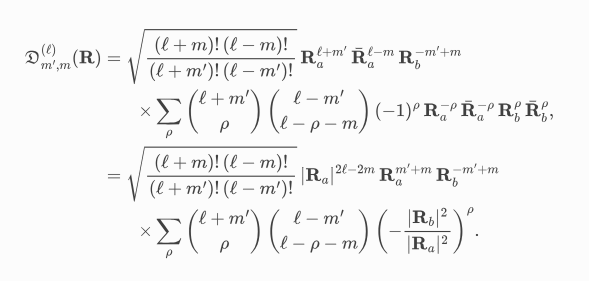

To execute it rapidly, it is best to pre-compute the combinatorial coefficients via a recursion.

In [69]:
def get_binomial_matrix(N_max):
    """
    Get N_max*N_max matrix with entries binomial_matrix[i, j]= (i choose j).
    
    Computed via Pascal's triangle recursion.
    """
    binomial_matrix = np.zeros((N_max+1, N_max+1))
    binomial_matrix[0,0] = binomial_matrix[1,0] = 1
    for i in range(1, N_max+1):
        for j in range(0, i+1):
            binomial_matrix[i, j] = binomial_matrix[i-1, j-1]+binomial_matrix[i-1, j]
    return binomial_matrix

In [70]:
%%timeit

get_binomial_matrix(20)

43.4 μs ± 289 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [71]:
get_binomial_matrix(20)[12, 3], special.comb(12, 3)

(220.0, 220.0)

In [72]:
#| export

def _get_wigner_D_element(Ra, Rb, l, mp, m, binomial_matrix):
    """
    Compute Wigner's D matrix element for a rotation defined by a unit quaternion R,
    represented as complex pair (R0+iR3), (R2+iR1). Requires pre-computed binomial matrix.
    
    Following https://spherical.readthedocs.io/en/main/WignerDMatrices/
    """
    comb_factor = np.sqrt(binomial_matrix[2*l, l+mp]/binomial_matrix[2*l, l+m])
    if np.abs(Ra) < 1e-10:
        if -mp != m:
            return 0
        return (-1)**(l+m) * Rb**(2*m)
    if np.abs(Rb) < 1e-10:
        if mp != m:
            return 0
        return Ra**(2*m)
    if np.abs(Ra) > np.abs(Rb):
        R_factor = np.abs(Ra)**(2*l-2*m) * Ra**(m+mp) * Rb**(m-mp)
        choose_factor = 0
        rho_min = max([mp-m, 0])
        power_fac = (np.abs(Rb)/np.abs(Ra))**2
        for rho in range(rho_min, l+mp+1):
            choose_factor += (binomial_matrix[l+mp, rho]*binomial_matrix[l-mp, l-rho-m]
                              *power_fac**(rho-rho_min)*(-1)**rho)
        return comb_factor*R_factor*choose_factor*power_fac**rho_min
    elif np.abs(Rb) > np.abs(Ra):
        R_factor = np.abs(Rb)**(2*l-2*m) * Ra**(m+mp) * Rb**(m-mp)
        choose_factor = 0
        rho_min = max([-mp-m, 0])
        power_fac = (np.abs(Ra)/np.abs(Rb))**2
        for rho in range(rho_min, l-mp+1):
            choose_factor += (binomial_matrix[l-mp, rho]*binomial_matrix[l+mp, l-rho-m]
                              *power_fac**(rho-rho_min)*(-1)**rho)
        return (-1)**(l-m)*comb_factor*R_factor*choose_factor*power_fac**rho_min

def get_wigner_D_matrix(q, l, binomial_matrix=None):
    """Get (2*l+1, 2*l+1) Wigner D matrix for angular momentum l and rotation R,
    represented by quaternion q"""
    matrix = np.zeros(((2*l+1, 2*l+1)), dtype="complex_")
    Ra, Rb = quaternion_to_complex_pair(q)
    if l == 0:
        matrix[0,0] = 1
        return matrix
    if binomial_matrix is None:
        binomial_matrix = get_binomial_matrix(2*l)
    for m in range(-l, l+1):
        for mp in range(-l, l+1):
            matrix[l+mp, l+m] = _get_wigner_D_element(Ra, Rb, l, mp, m, binomial_matrix=binomial_matrix)
    return matrix

In [73]:
%%timeit
mat = get_wigner_D_matrix(q, l=10) 
# 30 ms. all. down to 2 by binomial recursion

3.38 ms ± 68.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
get_wigner_D_matrix(q, l=10)[12, 2]

(-0.3379064677134426+0.04302288551385434j)

In [82]:
Q = stats.special_ortho_group.rvs(3)
q = rot_mat_to_quaternion(Q)

# q = np.array([ 0.99950656,  0.        ,  0.        , -0.03141076]) # special case: important to check

In [83]:
# compare with the spherical package. looks pretty good, small diff if q[0]==0

wigner = spherical.Wigner(15)
#D = wigner.D(quaternionic.array.from_rotation_matrix(Q))
D = wigner.D(q)

l = 2
binomial_matrix = get_binomial_matrix(2*l)
mp, m = (0, 0)

(D[wigner.Dindex(l, mp, m)],
 _get_wigner_D_element(*quaternion_to_complex_pair(q), l, mp, m, binomial_matrix),)

((-0.4144731244368259+0j), (-0.41447312443682566+0j))

In [84]:
%%time
mat = get_wigner_D_matrix(q, l=10) 
# a little slow

CPU times: user 2.83 ms, sys: 75 μs, total: 2.9 ms
Wall time: 2.97 ms


### Check that the Wigner D correctly re-aligns our harmonic coefficients

In [114]:
#| export


def rotate_spherical_harmonics_coeffs(q, coeffs):
    """
    Rotate spherical harmonics by given unit quaternion.
    
    Uses Wigner-D matrices. Don't use this function in an optimization context - 
    you can in general save a bunch of time by reusing D-matrices etc.
    
    Parameters
    ----------
    q : np.array of shape (4)
        Unit quaternion representing rotation. If you have a rotation matrix,
         use rot_mat_to_quaternion
    coeffs : dict of np.array
        Dictionary, indexed by total angular momentum l=0 ,..., max_l. Each entry is a vector
        of coefficients for the different values of m=-2l,...,2*l
    
    Returns
    -------
    coeffs_rotated : 2d np.array
        Rotated spherical harmonics coefficients.
    
    """
    return {key: get_wigner_D_matrix(q, l=key)@val for key, val in coeffs.items()}

In [115]:
l = 10

D_matrix = get_wigner_D_matrix(rot_mat_to_quaternion(rot_mat), l=l)

np.allclose(D_matrix@spherical_harmonics_coeffs_direct[l], spherical_harmonics_coeffs_rotated[l])
# success!

True

In [116]:
# before alignment, the coefficients are different
not np.allclose(spherical_harmonics_coeffs_direct[l], spherical_harmonics_coeffs_rotated[l])

True

### Cross-correlation analysis

We now want to find the rotation that maximises the cross-correlation between the two signals. To do so, we compute the overlap for a number of trial rotations to get an initial guess and refine it by optimization.

In [94]:
%%time 

# this is how you compute the overlap, here using the my code

max_l = 10
binomial_matrix = get_binomial_matrix(2*max_l)
R = np.copy(rot_mat)

corr_coeff = 0
for l in range(0, max_l):
    D_matrix = get_wigner_D_matrix(rot_mat_to_quaternion(R), l=l, binomial_matrix=binomial_matrix)
    corr_coeff += np.sum(D_matrix@spherical_harmonics_coeffs_direct[l]
                         *np.conjugate(spherical_harmonics_coeffs_rotated[l]))

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 10.9 ms


In [95]:
corr_coeff

(48.79549526557914-5.519923353581699e-17j)

In [97]:
%%time

# the spherical module is about 10x faster

wigner = spherical.Wigner(max_l)
D = wigner.D(quaternionic.array.from_rotation_matrix(R))

corr_coeff = 0
for l in range(0, max_l):
    D_matrix = np.array([[D[wigner.Dindex(l, m, mp)] for mp in range(-l, l+1)] for m in range(-l, l+1)])
    corr_coeff += (np.sum(D_matrix@spherical_harmonics_coeffs_direct[l]
                   *np.conjugate(spherical_harmonics_coeffs_rotated[l])))

CPU times: user 899 μs, sys: 26 μs, total: 925 μs
Wall time: 1.11 ms


In [98]:
corr_coeff

(48.79549526557914+7.784944420575928e-18j)

In [99]:
D[wigner.Dindex(l, mp, m)]

(-0.15923247483896824+0j)

Now let's consider multiple rotations. we can save time by minimizing the number of time we compute the D-matrix by using the fact that $D(R^n) = D(R)^n$ - hence, for every rotation axis, we can try out a large number of rotation angles efficiently.

In [100]:
D_mat = get_wigner_D_matrix(rot_mat_to_quaternion(R), l=2)
D_mat_of_square = get_wigner_D_matrix(rot_mat_to_quaternion(R@R), l=2)
np.allclose(D_mat@D_mat, D_mat_of_square)

True

In [102]:
%%time

max_l = 10
binomial_matrix = get_binomial_matrix(2*max_l)

n_axes = 100
n_powers = 100
corr_coeffs = np.zeros((n_axes, n_powers+1), dtype="complex_")

for i in range(n_axes): # iterate over rotation axes
    q = rot_mat_to_quaternion(R)
    correlation = np.zeros(n_powers+1,  dtype="complex_")
    for l in range(0, max_l):
        D_matrix = get_wigner_D_matrix(q, l=l, binomial_matrix=binomial_matrix)
        rotated_l = [D_matrix@spherical_harmonics_coeffs_direct[l]]
        for n in range(n_powers): # iterate over rotation strength via 
            rotated_l.append(D_matrix@rotated_l[-1])
        correlation += np.stack(rotated_l).dot(np.conjugate(spherical_harmonics_coeffs_rotated[l]))
    corr_coeffs[i] = correlation

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.02 s


In [949]:
corr_coeffs[0,0]

(48.795495265579056-2.3871463242869e-16j)

### Sampling the sphere

How do we get a good sampling of unit vectors on the sphere, a la healpix, for our initial guess? Let's use an "icosphere" https://en.wikipedia.org/wiki/Geodesic_polyhedron

In [103]:
#| export

def get_icosphere(subdivide=0):
    """
    Return the icosphere triangle mesh with 42 regulary spaced vertices on the unit sphere.
    
    Optionally, subdivide mesh n times, increasing vertex count by factor 4^n.
    """
    vertices = np.array([[ 0.      , -1.      ,  0.      ], [ 0.723607, -0.44722 ,  0.525725],
                         [-0.276388, -0.44722 ,  0.850649], [-0.894426, -0.447216,  0.      ],
                         [-0.276388, -0.44722 , -0.850649], [ 0.723607, -0.44722 , -0.525725],
                         [ 0.276388,  0.44722 ,  0.850649], [-0.723607,  0.44722 ,  0.525725],
                         [-0.723607,  0.44722 , -0.525725], [ 0.276388,  0.44722 , -0.850649],
                         [ 0.894426,  0.447216,  0.      ], [ 0.      ,  1.      ,  0.      ],
                         [-0.162456, -0.850654,  0.499995], [ 0.425323, -0.850654,  0.309011],
                         [ 0.262869, -0.525738,  0.809012], [ 0.850648, -0.525736,  0.      ],
                         [ 0.425323, -0.850654, -0.309011], [-0.52573 , -0.850652,  0.      ],
                         [-0.688189, -0.525736,  0.499997], [-0.162456, -0.850654, -0.499995],
                         [-0.688189, -0.525736, -0.499997], [ 0.262869, -0.525738, -0.809012],
                         [ 0.951058,  0.      ,  0.309013], [ 0.951058,  0.      , -0.309013],
                         [ 0.      ,  0.      ,  1.      ], [ 0.587786,  0.      ,  0.809017],
                         [-0.951058,  0.      ,  0.309013], [-0.587786,  0.      ,  0.809017],
                         [-0.587786,  0.      , -0.809017], [-0.951058,  0.      , -0.309013],
                         [ 0.587786,  0.      , -0.809017], [ 0.      ,  0.      , -1.      ],
                         [ 0.688189,  0.525736,  0.499997], [-0.262869,  0.525738,  0.809012],
                         [-0.850648,  0.525736,  0.      ], [-0.262869,  0.525738, -0.809012],
                         [ 0.688189,  0.525736, -0.499997], [ 0.162456,  0.850654,  0.499995],
                         [ 0.52573 ,  0.850652,  0.      ], [-0.425323,  0.850654,  0.309011],
                         [-0.425323,  0.850654, -0.309011], [ 0.162456,  0.850654, -0.499995]])
    faces = np. array([[ 0, 13, 12], [12, 14,  2], [12, 13, 14], [13,  1, 14],
                       [ 1, 13, 15], [ 0, 12, 17], [ 0, 17, 19], [ 0, 19, 16],
                       [ 1, 15, 22], [ 2, 14, 24], [ 3, 18, 26], [ 4, 20, 28],
                       [ 5, 21, 30], [ 1, 22, 25], [ 2, 24, 27], [ 3, 26, 29],
                       [ 4, 28, 31], [ 5, 30, 23], [ 6, 32, 37], [ 7, 33, 39],
                       [ 8, 34, 40], [ 9, 35, 41], [10, 36, 38], [38, 41, 11],
                       [38, 36, 41], [36,  9, 41], [41, 40, 11], [41, 35, 40],
                       [35,  8, 40], [40, 39, 11], [40, 34, 39], [34,  7, 39],
                       [39, 37, 11], [39, 33, 37], [33,  6, 37], [37, 38, 11],
                       [37, 32, 38], [32, 10, 38], [23, 36, 10], [23, 30, 36],
                       [30,  9, 36], [31, 35,  9], [31, 28, 35], [28,  8, 35],
                       [29, 34,  8], [29, 26, 34], [26,  7, 34], [27, 33,  7],
                       [27, 24, 33], [24,  6, 33], [25, 32,  6], [25, 22, 32],
                       [22, 10, 32], [30, 31,  9], [30, 21, 31], [21,  4, 31],
                       [28, 29,  8], [28, 20, 29], [20,  3, 29], [26, 27,  7],
                       [26, 18, 27], [18,  2, 27], [24, 25,  6], [24, 14, 25],
                       [14,  1, 25], [22, 23, 10], [22, 15, 23], [15,  5, 23],
                       [16, 21,  5], [16, 19, 21], [19,  4, 21], [19, 20,  4],
                       [19, 17, 20], [17,  3, 20], [17, 18,  3], [17, 12, 18],
                       [12,  2, 18], [15, 16,  5], [15, 13, 16], [13,  0, 16],])
    if subdivide > 0:
        vertices, faces = igl.loop(vertices, faces, number_of_subdivs=subdivide)
    vertices = (vertices.T/np.linalg.norm(vertices, axis=-1)).T
    return tcio.ObjMesh(vertices=vertices, faces=faces)

In [ ]:
### To do: reflections!!

In [104]:
#| export

def rotation_alignment_brute_force(sph_harmonics_source, sph_harmonics_target, 
                                   max_l=None, n_angle=100, n_subdiv_axes=1):
    """
    Compute rotational alignment between two signals on sphere by brute force.
    
    The two signals have to be represented by their spherical harmonics coefficients.
    Uses Wigner-D matrices to calculate the overlap between the two signals
    for a set of rotations and finds the rotation that maximzes the overlap.
    
    The trial rotations are generated by taking a set of approx. equidistant
    points on the 2d sphere as rotation axes, and a set of equally spaced
    angles [0,..., 2*pi] as rotation angles.
    
    The rotation is such that it transforms the source signal to match the target.
        
    Parameters
    ----------
    sph_harmonics_source : dict of np.array
        Dictionary, indexed by total angular momentum l=0 ,..., max_l. Each entry is a vector
        of coefficients for the different values of m=-2l,...,2*l. Source signal, to be
        transformed.
    sph_harmonics_target : dict of np.array
        Dictionary, indexed by total angular momentum l=0 ,..., max_l. Each entry is a vector
        of coefficients for the different values of m=-2l,...,2*l. Target signal.
    max_l : int
        Maximum angular momentum. If None, the maximum value available in the input
        spherical harmonics is used.
    n_angle : int
        Number of trial rotation angles [0,..., 2*pi]
    n_subdiv_axes : int
        Controls number of trial rotatio axes. Rotation axes are vertices of
        the icosphere which can be subdivided. There will be roughly
        40*4**n_subdiv_axes trial axes. This parameter has the strongest influence
        on the run time.
    
    Returns
    -------
    optimal_trial_rotation : 4d np.array
        Best trial rotation as unit quaternion.
    overlap : float
        Normalized overlap. 1=perfect alignment.
    """
    if max_l is None:
        max_l = min([max(sph_harmonics_source.keys()), max(sph_harmonics_target.keys())])

    alpha_0 = 2*np.pi/n_angle
    axes = get_icosphere(subdivide=n_subdiv_axes).vertices
    corr_coeffs = np.zeros((axes.shape[0], n_angle+1), dtype="complex_")
    for i, axis in enumerate(axes): # iterate over rotation axes
        q = np.hstack([[np.cos(alpha_0/2)], np.sin(alpha_0/2)*axis])
        correlation = np.zeros(n_angle+1,  dtype="complex_")
        for l in range(0, max_l):
            D_matrix = get_wigner_D_matrix(q, l=l)
            rotated_l = [D_matrix@sph_harmonics_source[l]]
            for n in range(n_angle): # iterate over rotation strength via 
                rotated_l.append(D_matrix@rotated_l[-1])
            correlation += np.stack(rotated_l).dot(np.conjugate(sph_harmonics_target[l]))
        corr_coeffs[i] = correlation
    max_index = np.unravel_index(np.argmax(np.abs(corr_coeffs)), corr_coeffs.shape)
    alpha_opt = max_index[1]*alpha_0
    q_opt = np.hstack([[np.cos(alpha_opt/2)], np.sin(alpha_opt/2)*axes[max_index[0]]])
    
    normalization = np.sqrt(np.sum([val.dot(np.conjugate(val)) for val in sph_harmonics_source.values()])
                           *np.sum([val.dot(np.conjugate(val)) for val in sph_harmonics_target.values()]))
    overlap = corr_coeffs[max_index]/normalization
    
    return q_opt, overlap

In [107]:
%%time

q_opt, overlap = rotation_alignment_brute_force(spherical_harmonics_coeffs_direct,
                                                spherical_harmonics_coeffs_rotated,
                                                max_l=10, n_angle=100, n_subdiv_axes=1)
q_opt, rot_mat_to_quaternion(rot_mat), overlap

CPU times: user 1.46 s, sys: 4 ms, total: 1.46 s
Wall time: 1.46 s


(array([-0.4539905 ,  0.61318123,  0.46843379, -0.44550105]),
 array([ 0.50338515, -0.60058341, -0.41721929,  0.46025104]),
 (0.9945740174789119-2.780393555155586e-16j))

In [108]:
axis_true = rot_mat_to_quaternion(R)[1:] / np.linalg.norm(rot_mat_to_quaternion(R)[1:])
alpha_true = 2*np.arccos(rot_mat_to_quaternion(R)[0])

axis_opt = q_opt[1:] / np.linalg.norm(q_opt[1:])
alpha_opt = 2*np.arccos(q_opt[0])

print(axis_opt, alpha_opt)
print(axis_true, alpha_true)

[ 0.68818938  0.52573553 -0.49999752] 4.084070449666731
[-0.69506969 -0.48285796  0.53265966] 2.0865685628182717


In [111]:
#| export

def _get_minus_overlap(q, sph_harmonics_source, sph_harmonics_target, max_l=None, binomial_matrix=None,):
    """
    Get negative overlap between spherical harmonics, as function of rotation q, for optimization.
    
    
    """
    if max_l is None:
        max_l = min([max(sph_harmonics_source.keys()), max(sph_harmonics_target.keys())])    
    corr_coeff = 0
    for l in range(0, max_l):
        D_matrix = get_wigner_D_matrix(q/np.linalg.norm(q),
                                       l=l, binomial_matrix=binomial_matrix)
        corr_coeff += np.sum(D_matrix@spherical_harmonics_coeffs_direct[l]
                             *np.conjugate(spherical_harmonics_coeffs_rotated[l]))
    normalization = np.sqrt(np.abs(np.sum([val.dot(np.conjugate(val)) for val in sph_harmonics_source.values()])
                                  *np.sum([val.dot(np.conjugate(val)) for val in sph_harmonics_target.values()])))
    return -np.abs(corr_coeff)/normalization

def rotation_alignment_refined(sph_harmonics_source, sph_harmonics_target, q_initial,
                               max_l=None, maxfev=200):
    """
    Refine rotational alignment between two signals on sphere by optimization.
    
    The two signals have to be represented by their spherical harmonics coefficients.
    Uses Wigner-D matrices to calculate the overlap between the two signals
    and uses Nelder-Mead optimization to find the best one.
    
    Requires a good initial guess for the rotation, as created by 
    rotation_alignment_brute_force.
    
    The rotation is such that it transforms the source signal to match the target.
        
    Parameters
    ----------
    sph_harmonics_source : dict of np.array
        Dictionary, indexed by total angular momentum l=0 ,..., max_l. Each entry is a vector
        of coefficients for the different values of m=-2l,...,2*l. Source signal, to be
        transformed.
    sph_harmonics_target : dict of np.array
        Dictionary, indexed by total angular momentum l=0 ,..., max_l. Each entry is a vector
        of coefficients for the different values of m=-2l,...,2*l. Target signal.
    q_initial : 4d np.array
        Initial rotation as quaternion
    max_l : int
        Maximum angular momentum. If None, the maximum value available in the input
        spherical harmonics is used.
    maxfev : int
        Number of function evaluations during optimization.This parameter has
        the strongest influence on the run time.
    
    Returns
    -------
    optimal_rotation : 4d np.array
        Best rotation as unit quaternion.
    overlap : float
        Normalized overlap. 1=perfect alignment.
    """
    if max_l is None:
        max_l = min([max(sph_harmonics_source.keys()), max(sph_harmonics_target.keys())])
    args = (sph_harmonics_source, sph_harmonics_target, max_l, get_binomial_matrix(2*max_l))
    sol = optimize.minimize(_get_minus_overlap, q_initial, args=args, method="Nelder-Mead", tol=1e-5,
                            options={"maxfev": maxfev})
    return sol.x/np.linalg.norm(sol.x), sol.fun



In [112]:
%%time
rotation_alignment_refined(spherical_harmonics_coeffs_direct, spherical_harmonics_coeffs_rotated, q_opt,
                           max_l=10, maxfev=200)

CPU times: user 1.37 s, sys: 20.2 ms, total: 1.39 s
Wall time: 1.35 s


(array([-0.50338548,  0.60058266,  0.41721987, -0.46025114]),
 -0.9964647776510319)

### How well does this work?

Looks pretty good! I find that using about 160 trial rotation axes in the brute force step (`subdiv=`) is a good choice - fewer trial axes lead to poor initial guesses.